In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Fri_Jan__6_16:45:21_PST_2023
Cuda compilation tools, release 12.0, V12.0.140
Build cuda_12.0.r12.0/compiler.32267302_0


In [2]:
!python3 --version

Python 3.10.12


In [3]:
!nvidia-smi

Sun Sep 22 16:13:50 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.107.02             Driver Version: 550.107.02     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1060        Off |   00000000:01:00.0  On |                  N/A |
| N/A   64C    P8              4W /   78W |      48MiB /   6144MiB |      4%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Api

In [4]:
import time
import numpy as np
import os
import _pickle as cPickle
import numpy as np
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import label_to_name as IMAGENET_CLASS_NAMES
import pycuda.autoinit
import pycuda.driver as drv
import numpy
from PIL import Image
import imagehash

from pycuda.compiler import SourceModule

PATH = "../data/cifar-10-batches-py/"
IMAGENET_PATH = "../data/Imagenet32_train/"

In [5]:
def unpickleImages(pairs):
    images = set()
    for elem in pairs:
        images.add(elem[0])
        images.add(elem[1])

    return list(images)

def load_batch(batchFile, path):
    f = open(path+batchFile, 'rb')
    
    dict_ = cPickle.load(f, encoding='latin1')
    images = dict_['data']
    labels = dict_['labels']
    imagearray = np.array(images)   #   (10000, 3072)
    labelarray = np.array(labels)   #   (10000,)
    
    return imagearray, labelarray

def load_classes():
    file = 'batches.meta'
    
    f = open(PATH+file, 'rb')
    dict = cPickle.load(f)
    return dict['label_names']

In [6]:
unpickleImages([(1,2, 0.85),(3,4,0.34)])

[1, 2, 3, 4]

In [7]:
CIFAR_IMAGES, CIFAR_LABELS = load_batch("data_batch_1", PATH)
CIFAR_CLASS_NAMES = load_classes()
CIFAR_IMAGES.shape

(10000, 3072)

In [8]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

def load_databatch(data_folder, idx, img_size=32):
    data_file = os.path.join(data_folder, 'train_data_batch_')

    dict_ = unpickle(data_file + str(idx))

    images = dict_['data']
    labels = dict_['labels']

    return images, labels

In [9]:
IMAGENET_IMAGES, IMAGENET_LABELS = load_databatch(IMAGENET_PATH, 1)

In [10]:
def calculate_signature_np(image_file: np.array, hash_size: int) -> np.ndarray:
    pil_image = Image.fromarray(image_file).convert("L").resize(
                        (hash_size+1, hash_size),
                        Image.LANCZOS)
    dhash = imagehash.dhash(pil_image, hash_size)
    signature = dhash.hash.flatten()
    pil_image.close()
    return signature

In [11]:
from typing import List, Dict, Tuple

class cuPerceptual:
    def __init__(self, size, hash_size):
        self.buckets = []
        self.bandsNumber = size
        self.rows = int(hash_size**2 / self.bandsNumber)
        self.hash_buckets_list: List[Dict[int, List[str]]] = [dict() for _ in range(self.bandsNumber)]
        self.signatures = dict()
        self.hash_size = hash_size

        for i in range(size):
            self.buckets.append({})
            
    def fill_buckets(self, signature, idx):  # shingels
        for i in range(self.bandsNumber):
            signature_band = signature[i*self.rows:(i+1)*self.rows]
            signature_band_bytes = signature_band.tobytes()
            if signature_band_bytes not in self.hash_buckets_list[i]:
                self.hash_buckets_list[i][signature_band_bytes] = list()
            self.hash_buckets_list[i][signature_band_bytes].append(idx)
    
    def compute_hash(self, images):
        idx = 0;
        for image in images:
            signature = calculate_signature_np(image.T, self.hash_size)
            self.signatures[idx] = np.packbits(signature.astype(np.uint8))
            self.fill_buckets(signature, idx)
            idx+=1
        return self.signatures

    def compute_candidate(self):
        candidate_pairs = set()
        
        for hash_buckets in self.hash_buckets_list:
            for hash_bucket in hash_buckets.values():
                if len(hash_bucket) > 1:
                    hash_bucket = sorted(hash_bucket) # Why needed ?
                    for i in range(len(hash_bucket)):
                        for j in range(i+1, len(hash_bucket)):
                            candidate_pairs.add(
                                tuple([hash_bucket[i],hash_bucket[j]])
                            )
        return candidate_pairs

    def check_candidate(self, candidate_pairs, threshold=0.9):
        
        near_duplicates = list()
        for cpa, cpb in candidate_pairs:
            hd = sum(np.bitwise_xor(
                    np.unpackbits(self.signatures[cpa]), 
                    np.unpackbits(self.signatures[cpb])
            ))
            similarity = (self.hash_size**2 - hd) / self.hash_size**2
            if similarity > threshold:
                near_duplicates.append((cpa, cpb, similarity))
                
        # Sort near-duplicates by descending similarity and return
        near_duplicates.sort(key=lambda x:x[2], reverse=True)
        return near_duplicates

    def recheck_candidate(self, candidate_pairs, threshold=0.9):
        
        near_duplicates = list()
        for cpa, cpb,_ in candidate_pairs:
            hd = sum(np.bitwise_xor(
                    np.unpackbits(self.signatures[cpa]), 
                    np.unpackbits(self.signatures[cpb])
            ))
            similarity = (self.hash_size**2 - hd) / self.hash_size**2
            if similarity > threshold:
                near_duplicates.append((cpa, cpb, similarity))
                
        # Sort near-duplicates by descending similarity and return
        near_duplicates.sort(key=lambda x:x[2], reverse=True)
        return near_duplicates

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchvision.models import ResNet50_Weights

In [13]:
torch.set_default_device('cuda:0') 

In [14]:
class Net(nn.Module):
    def __init__(self, bits):
        super().__init__()
        #self.hash1 = nn.Linear(1000, 64)
        self.sigmoid = nn.Sigmoid()

    #def forward(self, x):
    #    hash_ = self.hash1(x)
    #    hash_ = self.sigmoid(hash_)
    #    hash_ = torch.round(hash_)
    #    return x.softmax(1), hash_

    def forward(self, x):
        #hash_ = self.hash1(x)
        hash_ = self.sigmoid(x)
        pred = torch.max(x, 1)[1]
        #print(pred)
        hash_ = torch.round(hash_)
        #hash_ *= 100
        #print(hash_.shape)
        #hash_ = hash_[:,0:256]
        #print(hash_.shape)
        return x.softmax(1), hash_

HASH_SIZE=64
device = 'cuda:0'
net = Net( HASH_SIZE )
net.to(device)

resnet50 = models.resnet50( weights=ResNet50_Weights.DEFAULT )
resnet50 = resnet50.to(device)

model = nn.Sequential(resnet50, net)
model = model.to(device)
model = model.eval()

In [15]:
for param in model.parameters():
    param.requires_grad = False

In [16]:
from typing import List, Dict, Tuple

class cuNN:
    def __init__(self, size, hash_size, images, size_images ):
        self.buckets = []
        self.bandsNumber = size
        self.rows = int(hash_size / self.bandsNumber)
        self.hash_buckets_list: List[Dict[int, List[str]]] = [dict() for _ in range(self.bandsNumber)]
        self.signatures = np.zeros([len(images), hash_size//8 ]).astype(np.float32)
        self.hash_size = hash_size
        self.images = images;
        self.size_ = size_images

        for i in range(size):
            self.buckets.append({})
            
    def fill_buckets(self, signature, idx):
        for i in range(self.bandsNumber):
            signature_band = signature[i*self.rows:(i+1)*self.rows]
            signature_band_bytes = signature_band.tobytes()
            if signature_band_bytes not in self.hash_buckets_list[i]:
                self.hash_buckets_list[i][signature_band_bytes] = list()
            self.hash_buckets_list[i][signature_band_bytes].append(idx)

    def compute_hash(self):
        
        tensor_image = torch.FloatTensor(self.images).to("cuda:0")
        label, hash_ = model(tensor_image)
        signatures = torch.round(hash_).cpu().detach().numpy().astype(np.int8)
        
        idx = 0
        for signature in signatures:
            self.signatures[idx] = np.packbits( signature ).astype(np.float32)
            self.fill_buckets(signature, idx)
            idx+=1
        return self.signatures
    
    def compute_candidate(self):
        candidate_pairs = set()

        for hash_buckets in self.hash_buckets_list:
            for hash_bucket in hash_buckets.values():
                if len(hash_bucket) > 1:
                    hash_bucket = sorted(hash_bucket)
                    for i in range(len(hash_bucket)):
                        for j in range(i+1, len(hash_bucket)):
                            candidate_pairs.add(
                               tuple([hash_bucket[i], hash_bucket[j]])
                            )
        return candidate_pairs
    
    def check_candidate(self, candidate_pairs, threshold=0.9):
        near_duplicates = list()
        for cpa, cpb in candidate_pairs:
            item_cpa = np.array(self.signatures[cpa]).astype(np.uint8)
            item_cpb = np.array(self.signatures[cpb]).astype(np.uint8)
            hd = sum(np.bitwise_xor(
                    np.unpackbits(item_cpa), 
                    np.unpackbits(item_cpb)
            ))
            similarity = (self.hash_size - hd) / self.hash_size
            if similarity > threshold:
                near_duplicates.append((cpa, cpb, similarity))
                
        # Sort near-duplicates by descending similarity and return
        near_duplicates.sort(key=lambda x:x[2], reverse=True)
        return near_duplicates

    def recheck_candidate(self, candidate_pairs, threshold=0.9):
        near_duplicates = list()
        for cpa, cpb,_ in candidate_pairs:
            item_cpa = np.array(self.signatures[cpa]).astype(np.uint8)
            item_cpb = np.array(self.signatures[cpb]).astype(np.uint8)
            hd = sum(np.bitwise_xor(
                    np.unpackbits(item_cpa), 
                    np.unpackbits(item_cpb)
            ))
            similarity = (self.hash_size - hd) / self.hash_size
            if similarity > threshold:
                near_duplicates.append((cpa, cpb, similarity))
                
        # Sort near-duplicates by descending similarity and return
        near_duplicates.sort(key=lambda x:x[2], reverse=True)
        return near_duplicates

In [17]:
#IMG = CIFAR_IMAGES[0:10000].reshape(10000,3,32,32)
#LABELS = CIFAR_LABELS
#print(IMG.shape)

IMG = IMAGENET_IMAGES[0:10000].reshape(10000,3,32,32)
LABELS = IMAGENET_LABELS
print(IMG.shape)

(10000, 3, 32, 32)


In [31]:
#nnLSH = cuNN(8, 64, IMG, len(IMG))
nnLSH = cuNN(25, 1000, IMG, len(IMG))
signatures = nnLSH.compute_hash()
print(signatures.shape)

pairs = nnLSH.compute_candidate()
print(len(pairs))

duplicates = nnLSH.check_candidate(pairs, 0.98)
print(len(duplicates))

perceptualLSH = cuPerceptual(8, 8)
perceptualLSH.compute_hash(IMG)
duplicates2 = perceptualLSH.recheck_candidate(duplicates,0.9)
print(len(duplicates2))


(10000, 125)
580254
6076
0


IndexError: list index out of range

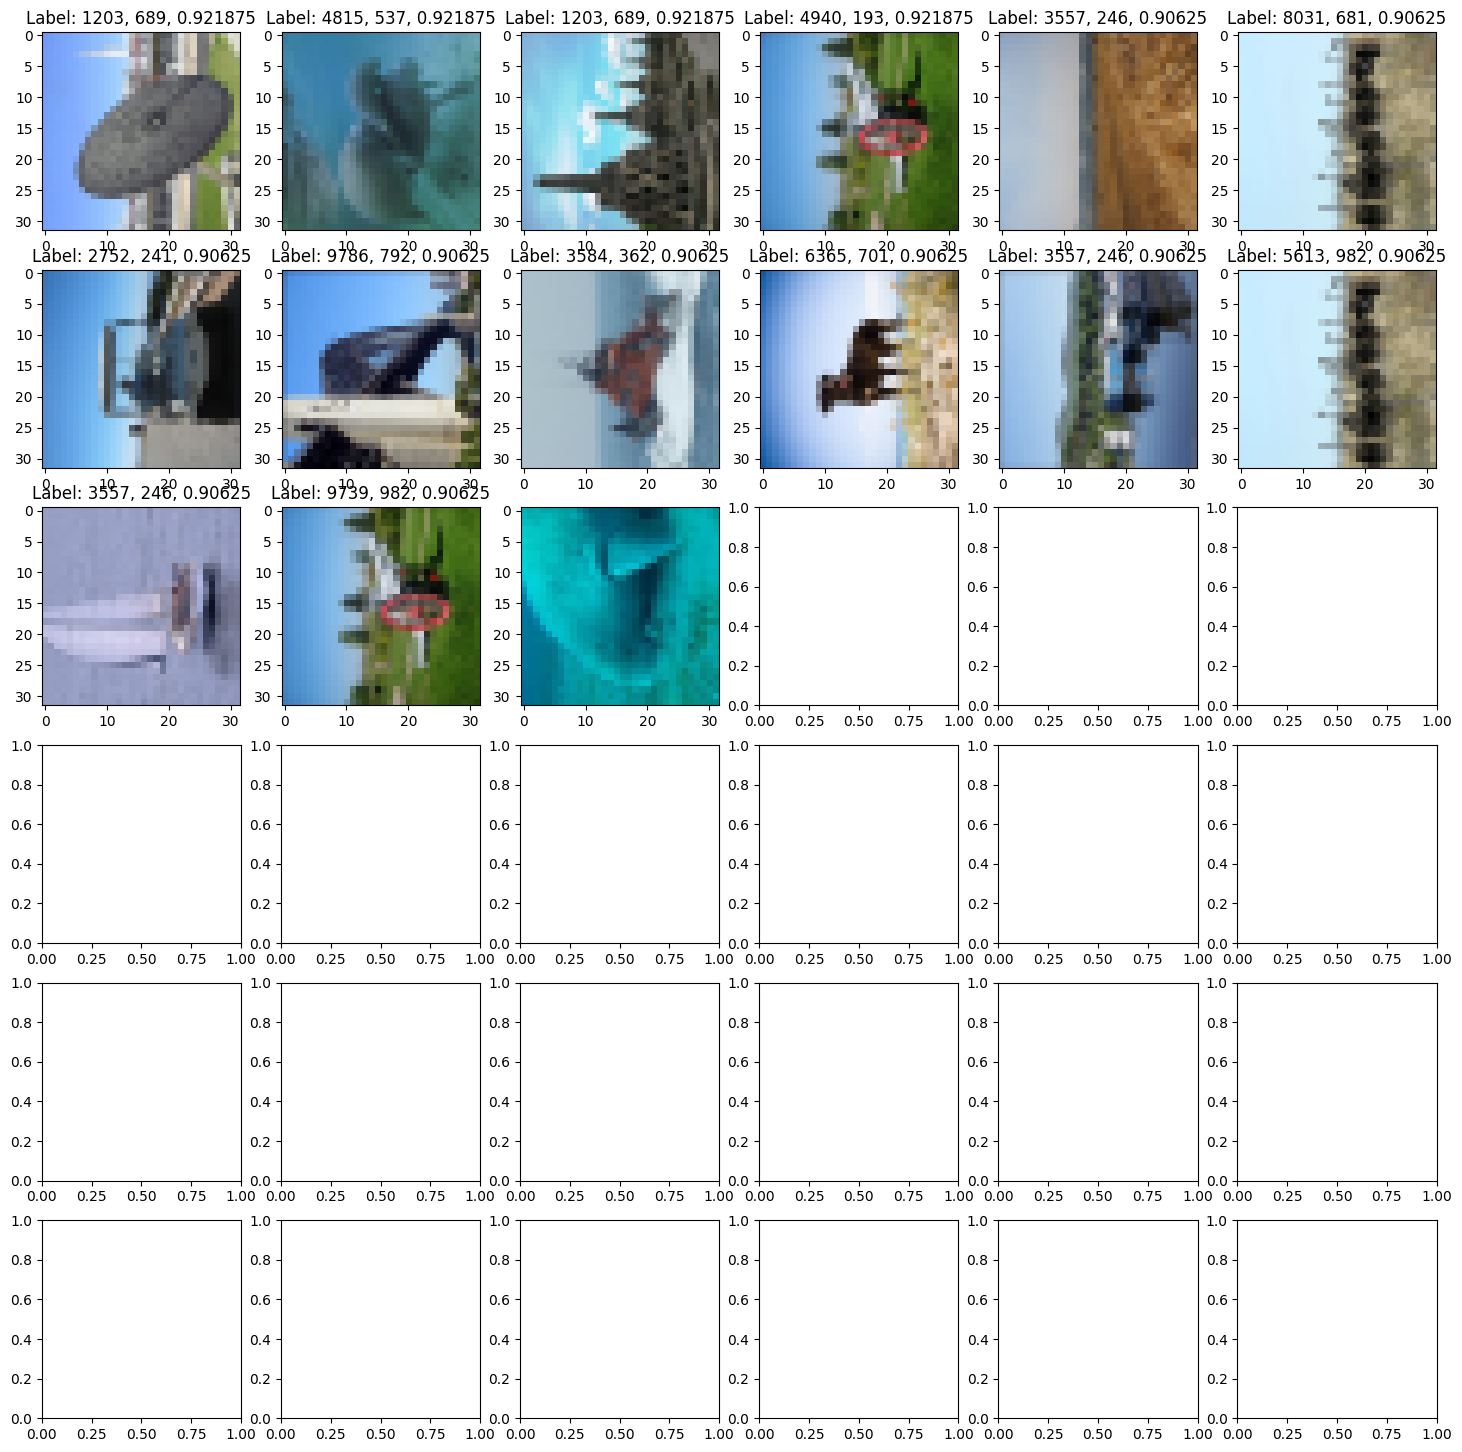

In [28]:
from matplotlib import pyplot as plt

num_row = 6
num_col = 6
col_idx = 0
row_idx = 0

idx_start = 0;

fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(0, num_row*num_col//2, 1):
    if col_idx >= num_col -1:
        col_idx = 0
        row_idx += 1
    
    ax = axes[row_idx, col_idx]
    ax.imshow(IMG[duplicates[i + idx_start ][0]].reshape(3,32,32).T)
    ax.set_title(f"""Label: {duplicates2[i + idx_start ][0]}, {LABELS[duplicates2[i + idx_start ][0]]}, {duplicates2[i + idx_start][2]}""")

    col_idx += 1
    ax = axes[row_idx, col_idx]
    ax.imshow(IMG[duplicates[i + idx_start][1]].reshape(3,32,32).T)
    ax.set_title(f"""Label: {duplicates2[i + idx_start][1]}, {LABELS[duplicates2[i + idx_start][1]]}, {duplicates2[i + idx_start][2]}""")
    col_idx += 1

plt.tight_layout()
plt.xticks([])
plt.yticks([])

plt.show()

In [40]:
withoutLastElements = 0#577600
sumTrueDuplicates = 0
for i in range( len(duplicates) - withoutLastElements ):
    if LABELS[duplicates[i][0]] == LABELS[duplicates[i][1]]:
        sumTrueDuplicates += 1
        

print("True duplicates: ", sumTrueDuplicates)
print("All duplicates: ", len(duplicates) - withoutLastElements )
acc = sumTrueDuplicates / ( len(duplicates) - withoutLastElements )
print(acc)

True duplicates:  30
All duplicates:  6076
0.004937458854509546


In [41]:
withoutLastElements = 0#577600
sumTrueDuplicates = 0
for i in range( len(duplicates2) - withoutLastElements ):
    if LABELS[duplicates2[i][0]] == LABELS[duplicates2[i][1]]:
        sumTrueDuplicates += 1
        

print("True duplicates: ", sumTrueDuplicates)
print("All duplicates: ", len(duplicates2) - withoutLastElements )
acc = sumTrueDuplicates / ( len(duplicates2) - withoutLastElements )
print(acc)

True duplicates:  0
All duplicates:  0


ZeroDivisionError: division by zero

# Second 

In [34]:
perceptualLSH = cuPerceptual(8, 8)
perceptualLSH.compute_hash(IMG)
pairs3 = perceptualLSH.compute_candidate()
duplicates3 = perceptualLSH.check_candidate(pairs3,0.8)
print(len(duplicates3))

nnLSH = cuNN(32, 1000, IMG, len(IMG))
signatures4 = nnLSH.compute_hash()
duplicates4 = nnLSH.recheck_candidate(duplicates3, 0.9)
print(len(duplicates4))


5219
152


In [35]:
# Treshold wwazny zeby odfiltrowac nie duplikaty
# Porownywanie duplikatow zdjec - przy podwojnym filtrowaniu ???
# 6 milionow par potencjalych przy sieci neuronowej
# Pierw musi chodzic PyCUDA poniej doperio cos PyTorch, zeby nie bylo przeklama w dostepie do cuda

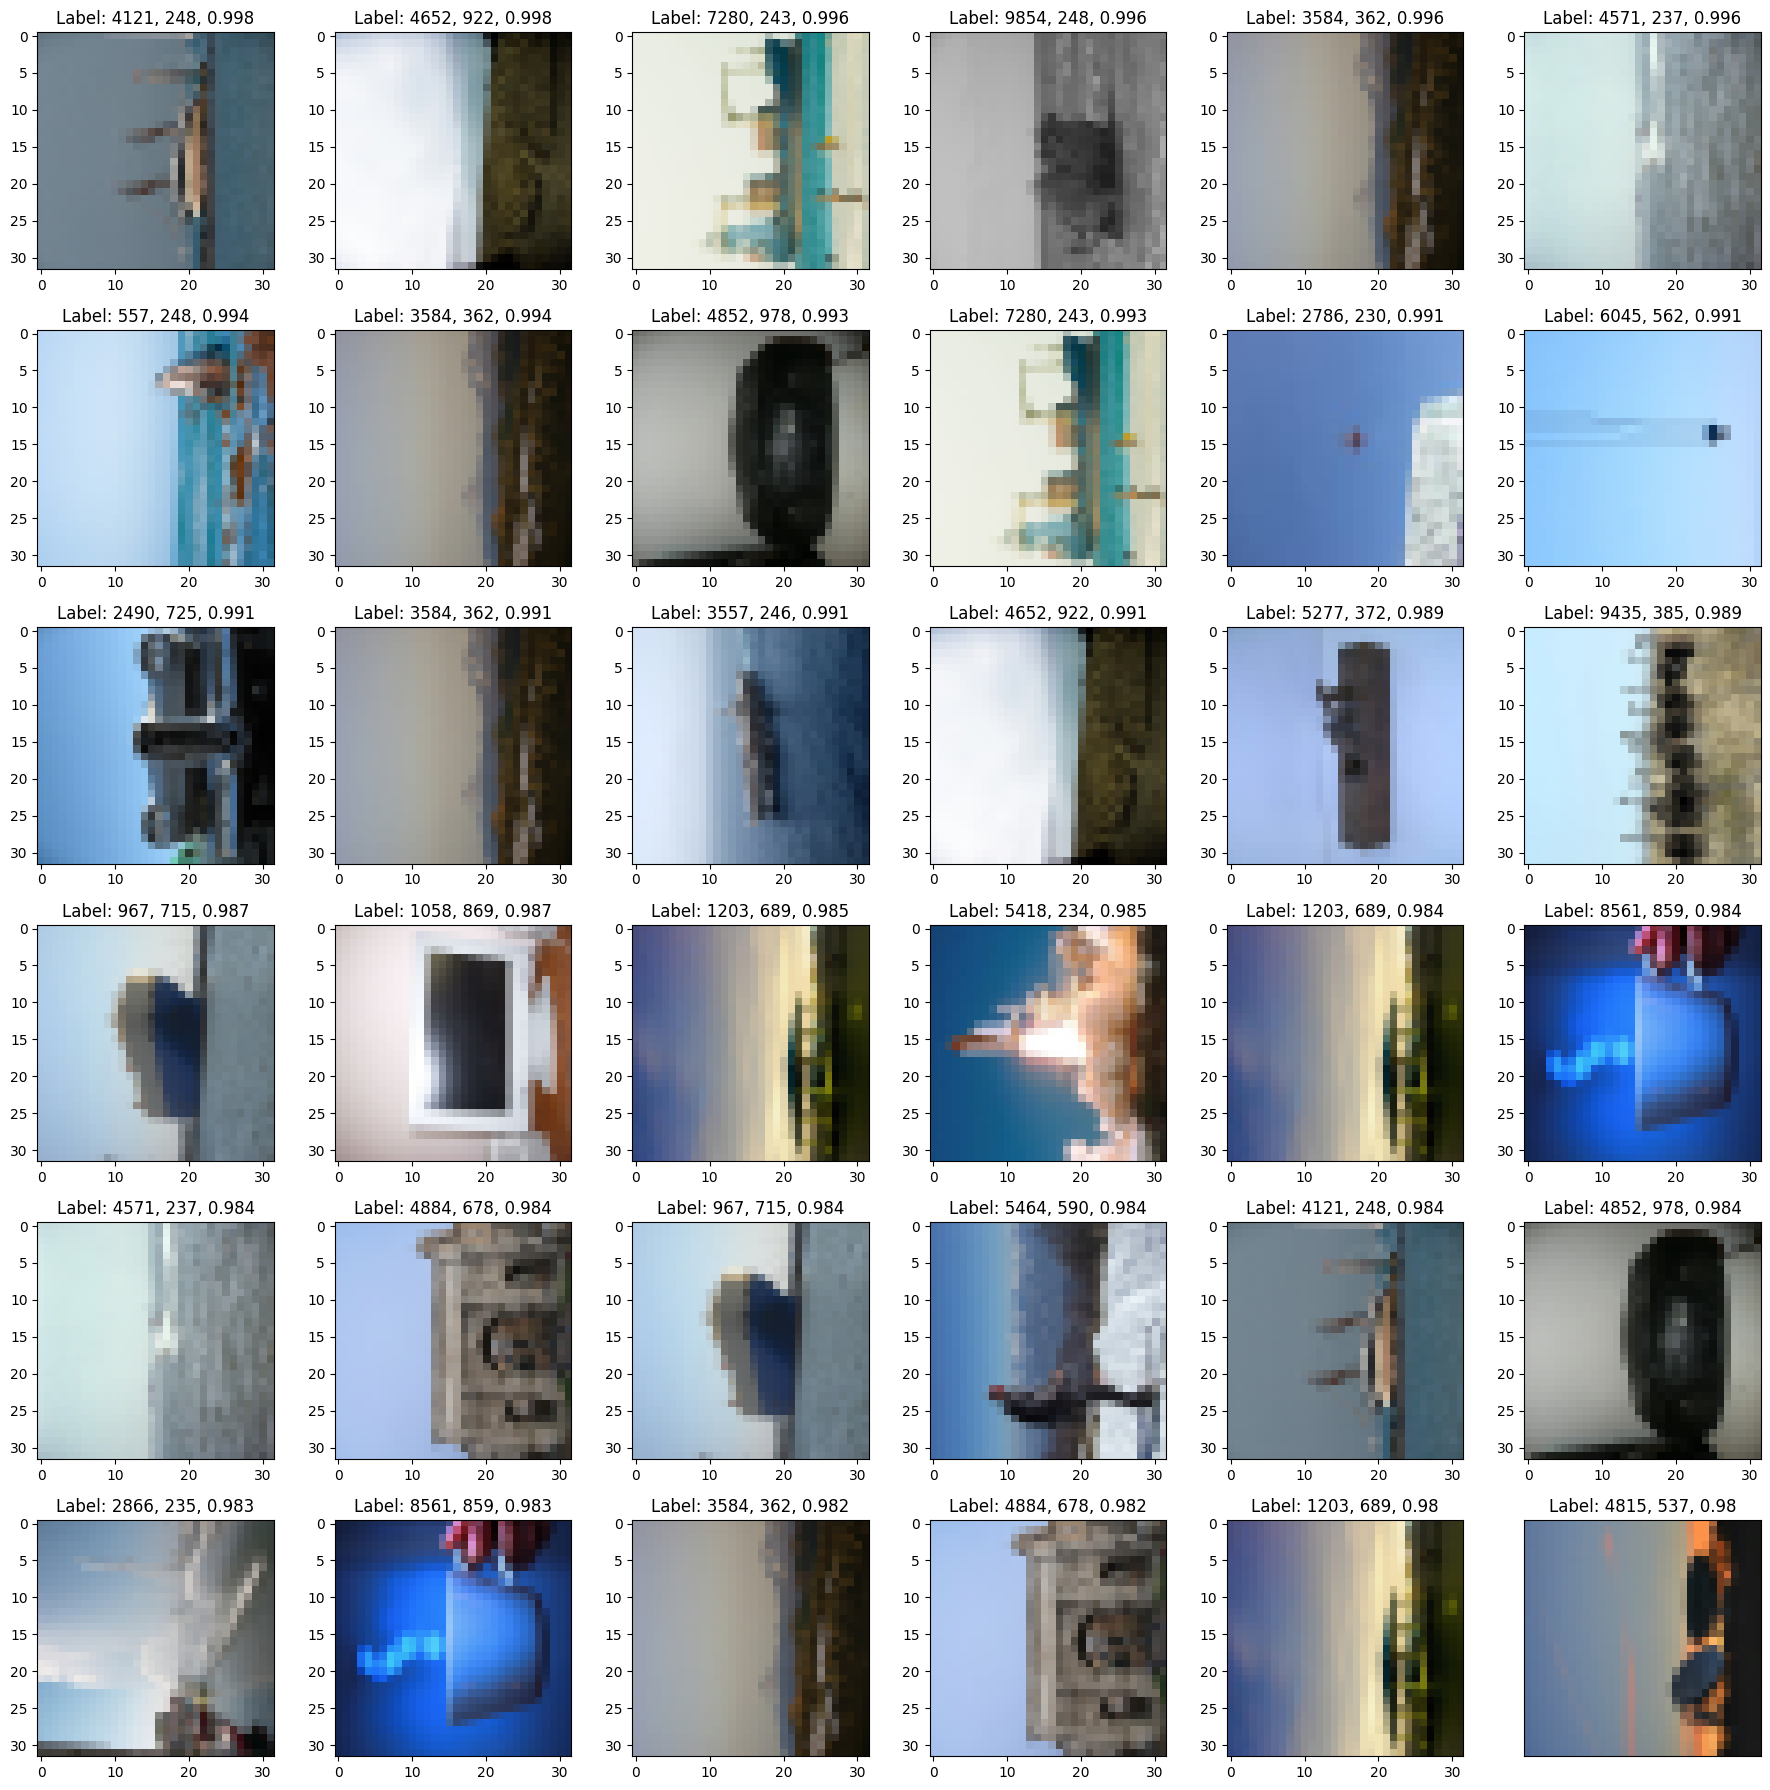

In [42]:
from matplotlib import pyplot as plt

num_row = 6
num_col = 6
col_idx = 0
row_idx = 0

idx_start = 0;

fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(0, num_row*num_col//2, 1):
    if col_idx >= num_col -1:
        col_idx = 0
        row_idx += 1
    
    ax = axes[row_idx, col_idx]
    ax.imshow(IMG[duplicates4[i + idx_start ][0]].reshape(3,32,32).T)
    ax.set_title(f"""Label: {duplicates4[i + idx_start ][0]}, {LABELS[duplicates4[i + idx_start ][0]]}, {duplicates4[i + idx_start][2]}""")

    col_idx += 1
    ax = axes[row_idx, col_idx]
    ax.imshow(IMG[duplicates4[i + idx_start][1]].reshape(3,32,32).T)
    ax.set_title(f"""Label: {duplicates4[i + idx_start][1]}, {LABELS[duplicates4[i + idx_start][1]]}, {duplicates4[i + idx_start][2]}""")
    col_idx += 1

plt.tight_layout()
plt.xticks([])
plt.yticks([])

plt.show()

In [43]:
withoutLastElements = 0#577600
sumTrueDuplicates = 0
for i in range( len(duplicates3) - withoutLastElements ):
    if LABELS[duplicates3[i][0]] == LABELS[duplicates3[i][1]]:
        sumTrueDuplicates += 1
        

print("True duplicates: ", sumTrueDuplicates)
print("All duplicates: ", len(duplicates3) - withoutLastElements )
acc = sumTrueDuplicates / ( len(duplicates3) - withoutLastElements )
print(acc)

True duplicates:  24
All duplicates:  5219
0.0045985821038513125


In [44]:
withoutLastElements = 0#577600
sumTrueDuplicates = 0
for i in range( len(duplicates4) - withoutLastElements ):
    if LABELS[duplicates4[i][0]] == LABELS[duplicates4[i][1]]:
        sumTrueDuplicates += 1
        

print("True duplicates: ", sumTrueDuplicates)
print("All duplicates: ", len(duplicates4) - withoutLastElements )
acc = sumTrueDuplicates / ( len(duplicates4) - withoutLastElements )
print(acc)

True duplicates:  7
All duplicates:  152
0.046052631578947366
